# Tutorial

This tutorial shows the basic steps for creating netcdfs of daily means.  Optionally you can also upload to Google Cloud Buckets. For the production files for the fully documented WR17+18 data package see:

* `shapefile_processing.ipynb`
* `streamflow_processing.ipynb`
* `save_to_gcp.ipynb`
* `package_structure.ipynb`
  
## Description

The NOAA National Water Model Retrospective [dataset](https://registry.opendata.aws/nwm-archive/) is an open AWS dataset. It contains input and output from multi-decade CONUS retrospective simulations. 
This is hourly data. This notebook gets the streamflow data and creates daily means and then saves the processed data as netcdfs and uploads to a Google Cloud bucket.

The mean calculations take >2Gb of RAM so make sure to pick at 4Gb instance not the 2Gb default.

## Create the feature ids csv

The shape file is very large. Process and save the COMID (feature id) metadata as a parquet file which is more efficient than csv. Read the file in later when the feature ids are needed. Metadata on feature ids left in if needed.


In [44]:
import geopandas as gpd

# Path to the shapefile
# original: shapefile_path = "WR_18_NHD.shp"
shapefile_path = "../HUC2-18/NHDFlowline.shp"
gdf = gpd.read_file(shapefile_path) # Load. Ignore the linetype warning

/srv/conda/envs/notebook/lib/python3.12/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


In [45]:
# Clean up
gdf = gdf.drop(columns="geometry") # don't need

# Extract HUC-4 from REACHCODE
gdf["HUC4"] = gdf["REACHCODE"].str[:4]

# If you only want certain COMIDS
# gdf = gdf[gdf["HUC4"].isin(["1801"])]

# Create alias since the NWS model data uses feature_id for COMID
gdf["feature_id"] = gdf["COMID"]

gdf.to_parquet("metadata.parquet", index=False)

# If you prefer csv but much 3x bigger
#gdf.to_csv("metadata.csv", index=False)

In [46]:
gdf.HUC4.unique()

array(['1606', '1712', '1801', '1802', '1803', '1804', '1805', '1806',
       '1807', '1808', '1809', '1810'], dtype=object)

## Load in the Zarr file on AWS

Step one is to load in the Zarr file so we have all the data (lazily).

In [47]:
import xarray as xr
import fsspec

# Set storage options for anonymous S3 access
so = {
    "anon": True,
    "client_kwargs": {"region_name": "us-east-1"}
}

Now that we have specified the S3 access, we can load in the Zarr file lazily (just the metadata). The streamflow alone is 4.5 Tb.

In [2]:
%%time
# Path to the Zarr store
zarr_path = "s3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/chrtout.zarr"

# Open the Zarr dataset using xarray
ds = xr.open_zarr(zarr_path, storage_options=so, consolidated=True)

CPU times: user 2.87 s, sys: 221 ms, total: 3.09 s
Wall time: 8.76 s


In [55]:
# Peek at the dataset
ds["streamflow"]

<xarray.DataArray 'streamflow' (time: 385704, feature_id: 2776734)> Size: 9TB
dask.array<open_dataset-streamflow, shape=(385704, 2776734), dtype=float64, chunksize=(672, 30000), chunktype=numpy.ndarray>
Coordinates:
    elevation   (feature_id) float32 11MB dask.array<chunksize=(2776734,), meta=np.ndarray>
  * feature_id  (feature_id) int64 22MB 101 179 181 ... 1180001803 1180001804
    gage_id     (feature_id) |S15 42MB dask.array<chunksize=(2776734,), meta=np.ndarray>
    latitude    (feature_id) float32 11MB dask.array<chunksize=(2776734,), meta=np.ndarray>
    longitude   (feature_id) float32 11MB dask.array<chunksize=(2776734,), meta=np.ndarray>
    order       (feature_id) int32 11MB dask.array<chunksize=(2776734,), meta=np.ndarray>
  * time        (time) datetime64[ns] 3MB 1979-02-01T01:00:00 ... 2023-02-01
Attributes:
    grid_mapping:  crs
    long_name:     River Flow
    units:         m3 s-1

## Load in the feature_ids and create subset_ds

This is the key step. We will get the data we need (lazily) from the Zarr file and add any extra metadata (HUC4 and REACHCODE) that we want.  The feature ids were created in the parquet file above.

In [103]:
import pandas as pd

df = pd.read_parquet("metadata.parquet")
# df = pd.read_csv("metadata.csv") # if you used csv
streamriver_df = df[df["FTYPE"] == "StreamRiver"]
feature_ids = streamriver_df["COMID"].unique()
# Print summary
print(f"HUC4: {sorted(df['HUC4'].dropna().unique())}")
print(f"feature ids (COMIDs): {len(feature_ids)}")

HUC4: ['1606', '1712', '1801', '1802', '1803', '1804', '1805', '1806', '1807', '1808', '1809', '1810']
feature ids (COMIDs): 135804


In [104]:
# make sure feature_ids in the file are in the Zarr file
available_ids = ds.feature_id.values

# Convert your list to a NumPy array
import numpy as np
feature_ids = np.array(feature_ids, dtype=int)

# Find the intersection (only those that exist in the dataset)
valid_ids = np.intersect1d(feature_ids, available_ids)

print(f"{len(valid_ids)} of {len(feature_ids)} feature_ids matched the dataset.")

124480 of 135804 feature_ids matched the dataset.


In [121]:
# KEY STEP
# Subset the dataset and just get streamflow
subset_ds = ds["streamflow"].sel(feature_id=valid_ids)

### Add on REACHCODE

We want to be able to select on reach code in addition to feature id so we need to add them as coords in our xarray dataset. This is going to make working with the netcdf a lot easier. HUC4 code is the first 4 digits. This will increase the size of our netcdfs, but will make the netcdf much more useful since we can select by HUC4 or HUC8 code.

In [122]:
# Convert to xarray Dataset and align on feature_id
df = streamriver_df
df_xr = df.set_index("feature_id").to_xarray()

# Align with original dataset on feature_id coordinate
df_xr = df_xr.reindex(feature_id=subset_ds.feature_id)

# Attach to the dataset as new coordinates or data variables
subset_ds = subset_ds.assign_coords(
    REACHCODE=("feature_id", df_xr.REACHCODE.astype("S14").data),
)

In [127]:
# After we do this we can select a huc4 like this
huc4 = subset_ds.REACHCODE.str.startswith("1810")
subset_ds.sel(feature_id=huc4)

<xarray.DataArray 'streamflow' (time: 385704, feature_id: 6504)> Size: 20GB
dask.array<getitem, shape=(385704, 6504), dtype=float64, chunksize=(672, 6504), chunktype=numpy.ndarray>
Coordinates:
    elevation   (feature_id) float32 26kB dask.array<chunksize=(6504,), meta=np.ndarray>
  * feature_id  (feature_id) int64 52kB 22589857 22589859 ... 948100740
    gage_id     (feature_id) |S15 98kB dask.array<chunksize=(6504,), meta=np.ndarray>
    latitude    (feature_id) float32 26kB dask.array<chunksize=(6504,), meta=np.ndarray>
    longitude   (feature_id) float32 26kB dask.array<chunksize=(6504,), meta=np.ndarray>
    order       (feature_id) int32 26kB dask.array<chunksize=(6504,), meta=np.ndarray>
  * time        (time) datetime64[ns] 3MB 1979-02-01T01:00:00 ... 2023-02-01
    REACHCODE   (feature_id) |S14 91kB b'18100201003331' ... b'18100100000042'
Attributes:
    grid_mapping:  crs
    long_name:     River Flow
    units:         m3 s-1

### Looking at the chunks

`subset_ds` is pointing to the Zarr on S3. Let's look at the chunks. We can see that each chunk is 672 hours and 200036 feature_ids. That is the minimum size of data that we will be pulling in each time we query the Zarr, by doing something like `.load()`, `.compute()` or `.plot()`.

In [128]:
subset_ds

<xarray.DataArray 'streamflow' (time: 385704, feature_id: 124480)> Size: 384GB
dask.array<getitem, shape=(385704, 124480), dtype=float64, chunksize=(672, 29857), chunktype=numpy.ndarray>
Coordinates:
    elevation   (feature_id) float32 498kB dask.array<chunksize=(124480,), meta=np.ndarray>
  * feature_id  (feature_id) int64 996kB 341095 341097 ... 948100739 948100740
    gage_id     (feature_id) |S15 2MB dask.array<chunksize=(124480,), meta=np.ndarray>
    latitude    (feature_id) float32 498kB dask.array<chunksize=(124480,), meta=np.ndarray>
    longitude   (feature_id) float32 498kB dask.array<chunksize=(124480,), meta=np.ndarray>
    order       (feature_id) int32 498kB dask.array<chunksize=(124480,), meta=np.ndarray>
  * time        (time) datetime64[ns] 3MB 1979-02-01T01:00:00 ... 2023-02-01
    REACHCODE   (feature_id) |S14 2MB b'18040010039448' ... b'18100100000042'
Attributes:
    grid_mapping:  crs
    long_name:     River Flow
    units:         m3 s-1

## Make a hydrograph

In [52]:
# Select feature and year
fid = 341097
start = "2022-01-01"
end = "2022-12-31"

In [53]:
%%time
# load so we can use without reloading all the time;
# See above were we looked at the subset_ds chunks. Querying subset_ds, means we have to load all 
# 20k fids since the chunk has all. So this step will take a moment.
streamflow_ts = subset_ds.sel(feature_id=fid).sel(time=slice(start, end)).load()
# Note using slice() is slightly faster than the below
#streamflow_ts = subset_ds.sel(feature_id=fid).sel(time="2022").load()

CPU times: user 42.9 s, sys: 21.4 s, total: 1min 4s
Wall time: 35.8 s


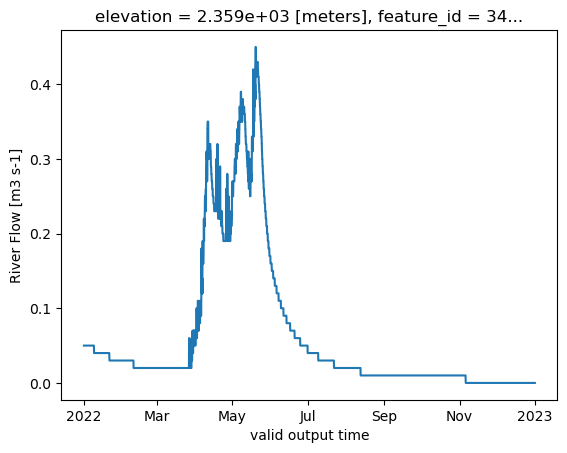

In [54]:
# plot
streamflow_ts.plot();

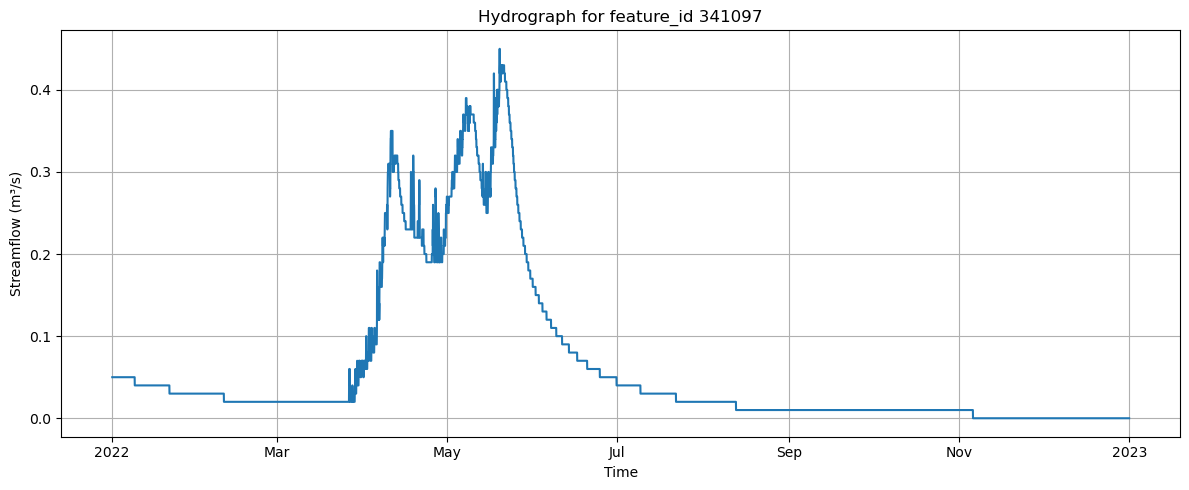

In [55]:
# prettier
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 5))
streamflow_ts.plot()
plt.title(f"Hydrograph for feature_id {fid}")
plt.xlabel("Time")
plt.ylabel("Streamflow (m³/s)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Let's compute the daily mean for a feature_id

For one year. 

In [15]:
%%time
streamflow_ts = subset_ds.isel(feature_id=1).sel(time="2022").load()
daily_mean = streamflow_ts.resample(time="1D").mean()

CPU times: user 44.8 s, sys: 22 s, total: 1min 6s
Wall time: 36.8 s


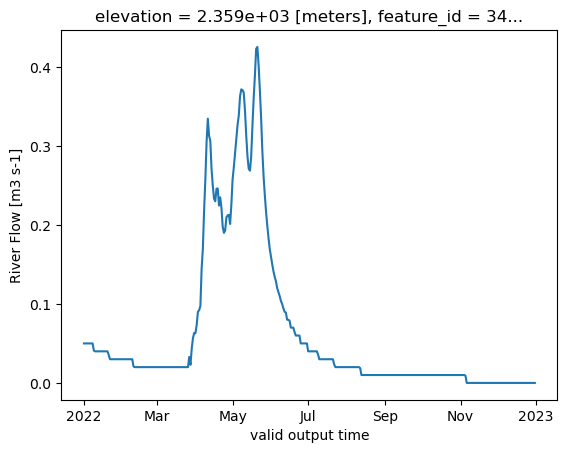

In [16]:
daily_mean.plot();

## Save the daily means

### One year, csv

We could save one year and one feature id to a csv. This is not very efficient at all. Fine for one year and one feature id but terrible if the goal is to do 100k feature ids.

In [36]:
filename = f"daily_mean_streamflow_fid{fid}_{year}.csv"
daily_mean.to_series().to_frame(name="streamflow").to_csv(filename, index=True)
print(f"Saved to {filename}")

Saved to daily_mean_streamflow_fid341097_2022.csv
CPU times: user 2.64 ms, sys: 125 µs, total: 2.77 ms
Wall time: 5.56 ms


## All years, two HUC4s, save to netcdf

Doing just one feature id is very inefficient as the bottleneck here is in the IO step (getting data from S3) and that pulls in all feature ids. Let's do all feature ids for each year in two HUC4s and save to netcdf. Note that xarray uses dask under the hood in the `.compute()` step and since our data is chunked (look at `print(subset_ds.chunks)`), dask will nicely do the computation in chunks that will not max out our RAM. I am using 7Gb RAM instance and this maxes out at about 3 Gb RAM.

First let's try doing all years to see how long each year takes. Each year takes about 1.75 minutes. So 44 years will take 77 minutes. Not too bad. The netcdf file size for these 2 HUC4s is 48Mb. If we kept all HUCs in WR18, the file size would be about 100Mb.

It is import to NOT use `.load()` on `subset_ds`. We need to use `.compute()` to trigger dask to do parallel computing.

In [132]:
# Subset 2 HUC4s and one year
huc4_mask = (
    subset_ds.REACHCODE.str.startswith("1801") |
    subset_ds.REACHCODE.str.startswith("1802")
)
streamflow_ts = subset_ds.sel(feature_id=huc4_mask, time="2018")

In [75]:
%%time
# Resample daily mean, preserving the feature_id dimension
# Dask works under the hood to make this parallel
# But keep in mind that the slow step is getting data from the Zarr. Subsetting to fewer fids will
# not really speed things up since it has to grab all the fids anyhow.

daily_mean = streamflow_ts.resample(time="1D").mean().compute()

CPU times: user 2min 15s, sys: 1min 3s, total: 3min 19s
Wall time: 1min 42s


### Simple approach no chunking (bad idea)

We could do this but the files would be much bigger than necessary and when we wanted to use them in the cloud we would have to load the whole file. Ack. Also we have already seen how having to load in 20k+ fids is slowing things down. Let's make our fid chunks a bit smaller.

In [9]:
for year in range(1979, 2024):  # NWM 3.0 range
    print(f"Processing {year}...")
    
    # Subset 1 year
    year_ts = subset_ds.sel(time=str(year), feature_id=valid_huc_ids)

    # Resample daily mean
    daily_mean = year_ts.resample(time="1D").mean().compute()

    # Save as netcdf
    daily_mean.to_netcdf(f"daily_mean_{year}.nc")

Processing 1979...
Processing 1980...
Processing 1981...
Processing 1982...
Processing 1983...
Processing 1984...
Processing 1985...
Processing 1986...
Processing 1987...
Processing 1988...
Processing 1989...
Processing 1990...
Processing 1991...
Processing 1992...
Processing 1993...
Processing 1994...
Processing 1995...
Processing 1996...
Processing 1997...
Processing 1998...
Processing 1999...
Processing 2000...
Processing 2001...
Processing 2002...
Processing 2003...
Processing 2004...
Processing 2005...
Processing 2006...
Processing 2007...
Processing 2008...
Processing 2009...
Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
Processing 2019...
Processing 2020...
Processing 2021...
Processing 2022...


### Much better approach. Chunk the data.

All our great `xarray` and `dask` parallel tooling requires that our datasets are chunked. Let's do that from the get go. We will also compress which will make our files much smaller.

In [133]:
for year in range(1979, 1981):  # NWM 3.0 range is 1979 to 2023
    print(f"🔄 Processing {year}...")
    
    # Subset 1 year
    year_ts = subset_ds.sel(time=str(year), feature_id=huc4_mask)

    # Resample daily mean and compute
    daily_mean = year_ts.resample(time="1D").mean().compute()

    # Get correct chunk sizes based on dim order (likely time, feature_id)
    time_chunk = daily_mean.sizes["time"]
    feature_chunk = min(5000, daily_mean.sizes["feature_id"])

    # Apply chunking in memory (optional but helpful for clarity)
    daily_mean = daily_mean.chunk({"feature_id": feature_chunk})

    # Set encoding
    encoding = {
        "streamflow": {
            "chunksizes": (time_chunk, feature_chunk),  # match (time, feature_id)
            "zlib": True,
            "complevel": 4
        }
    }

    # Save with compression and chunking
    out_path = f"daily_mean_{year}.nc"
    daily_mean.to_netcdf(out_path, encoding=encoding, engine="netcdf4")

    print(f"✅ Saved {out_path}")


🔄 Processing 1979...
✅ Saved daily_mean_1979.nc
🔄 Processing 1980...
✅ Saved daily_mean_1980.nc


### Test loading

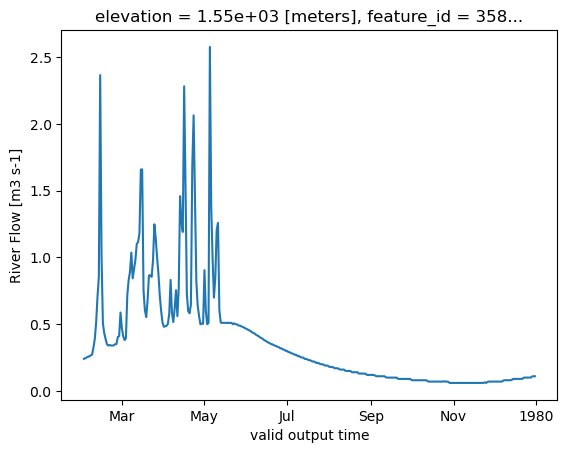

In [139]:
import xarray as xr
test_ds = xr.open_dataset("daily_mean_1979.nc")
test_ds.streamflow.isel(feature_id=1).plot()

## Uploading to Google Cloud

This will upload to Google Cloud and create a VirtualiZarr json file that we can use to lazy load all the data without making it a Zarr because R doesn't play nice with Zarr. Why do we want Zarr? Zarr stored in a cloud-bucket is optimized for cloud-native, parallel, and scalable processing with tools like Dask, Xarray, and machine-learning libraries. Since that is our eventual goal, we want the data stored in the optimized format for the future tasks.

Scroll down to the bottom to see the actual code I ran that creates proper netcdfs and Zarr with attributes needed for fully documented and cf-compliant data files.

### Prerequisites

The `py-rocket-geospatial-2` image on the NMFS Openscapes JuptyerHub is already set up with this.

* `pip install google-cloud-storage`
* `sudo apt-get install google-cloud-sdk`

You need to have the Storage Admin role on the bucket or on the folder of a bucket. For example, if you will be uploading to the [NOAA Fisheries Google NODD Public Buckets](https://www.noaa.gov/nodd/datasets#NMFS), you will need to be added as a Storage Admin role to a specific folder.

## Authenticate

Run the following in a terminal. It will open and you authenticate there. It will save `application_default_credentials.json` to `~/.config/gcloud`. If you do not have `google-cloud-sdk` installed, you can install somewhere (like locally) and then copy that file and create it here (in hub or whereever you are running this tutorial).

## Upload the netcdf files


In [ ]:
# set up bucket client
# stop annoying warnings
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

from google.cloud import storage
from pathlib import Path

# === Set these ===
bucket_name = "nmfs_odp_nwfsc"

# Create client and bucket
client = storage.Client(project="noaa-gcs-public-data")
bucket = client.bucket(bucket_name)

### Test file

In [ ]:
# Set the file you want to test with
test_file = Path("daily_mean_2018.nc")  # change this if using a different file
destination_prefix = "CB/nwm_daily_means/netcdf"

# Create blob and upload
blob_path = f"{destination_prefix}/{test_file.name}"
blob = bucket.blob(blob_path)
blob.upload_from_filename(str(test_file))

print(f"Uploaded {test_file.name} → gs://{bucket_name}/{blob_path}")

## All files

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

# Find all .nc files in current directory
nc_files = sorted(Path(".").glob("daily_mean_*.nc"))
destination_prefix = "CB/nwm_daily_means/netcdf"

for file_path in nc_files:
    destination_blob = f"{destination_prefix}/{file_path.name}"
    blob = bucket.blob(destination_blob)
    blob.upload_from_filename(str(file_path))
    print(f"✅ Uploaded {file_path.name} → gs://{bucket_name}/{destination_blob}")


## Lazy loading a file and plotting

In [ ]:
import xarray as xr
import fsspec
url = "gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/netcdf/daily_mean_2018.nc"
fs = fsspec.filesystem("gcs", anon=True) # anon=True since this is a public bucket
f = fs.open(url, mode="rb") # Open file
ds = xr.open_dataset(f)  # lazy load
subset = ds.isel(feature_id=1).sel(time=slice("2018-01-01", "2018-01-10"))
subset["streamflow"].plot()
f.close() # close the file when you're completely done

## Summary

1. Process the flowline shapefile to get the feature_ids (COMID ids)
2. Read in the Zarr file for the NWS model data
3. Process that year by year to get the daily means
4. Save each year to a chunked netcdf (chunked so access more efficient later)
5. Upload to Google Cloud bucket

## Extra upload to GCP without saving locally

In [ ]:
# set up bucket client
# stop annoying warnings
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

import io
from google.cloud import storage
from pathlib import Path

# === Set these ===
bucket_name = "nmfs_odp_nwfsc"

# Create client and bucket
client = storage.Client(project="noaa-gcs-public-data")
bucket = client.bucket(bucket_name)

destination_prefix = "CB/nwm_daily_means/netcdf"

for year in range(1979, 2024):
    print(f"🔄 Processing {year}...")

    year_ts = subset_ds.sel(time=str(year))

    # Keep this small while computing
    daily_mean = year_ts.resample(time="1D").mean().compute()

    time_chunk = daily_mean.sizes["time"]
    feature_chunk = min(5000, daily_mean.sizes["feature_id"])
    daily_mean = daily_mean.chunk({"feature_id": feature_chunk})

    encoding = {
        "streamflow": {
            "chunksizes": (time_chunk, feature_chunk),
            "zlib": True,
            "complevel": 4
        }
    }

    # Stream to GCS
    with io.BytesIO() as buffer:
        daily_mean.to_netcdf(buffer, encoding=encoding, engine="netcdf4", format="NETCDF4")
        buffer.seek(0)

        destination_blob = f"{destination_prefix}/daily_mean_{year}.nc"
        blob = bucket.blob(destination_blob)
        blob.upload_from_file(buffer, content_type="application/x-netcdf")

    print(f"✅ Uploaded daily_mean_{year}.nc → gs://{bucket.name}/{destination_blob}")
